<a href="https://colab.research.google.com/github/JuyoungYang/Practice/blob/main/boston_housing_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

In [2]:
uploaded = files.upload()

Saving housingdata.csv to housingdata.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 전처리 및 탐색

In [5]:
# 데이터 로드
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

In [7]:
# 기본 정보 확인
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB
None


In [8]:
# 결측치 확인
print(df.isnull().sum())

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64


In [9]:
# 기술통계량
print(df.describe())

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  486.000000  486.000000  486.000000  486.000000  506.000000  506.000000   
mean     3.611874   11.211934   11.083992    0.069959    0.554695    6.284634   
std      8.720192   23.388876    6.835896    0.255340    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.081900    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.253715    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.560263   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  486.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.518519    3.795043    9.549407  408.237154   18.455534  356.674032   
std     27.999513    2.1057

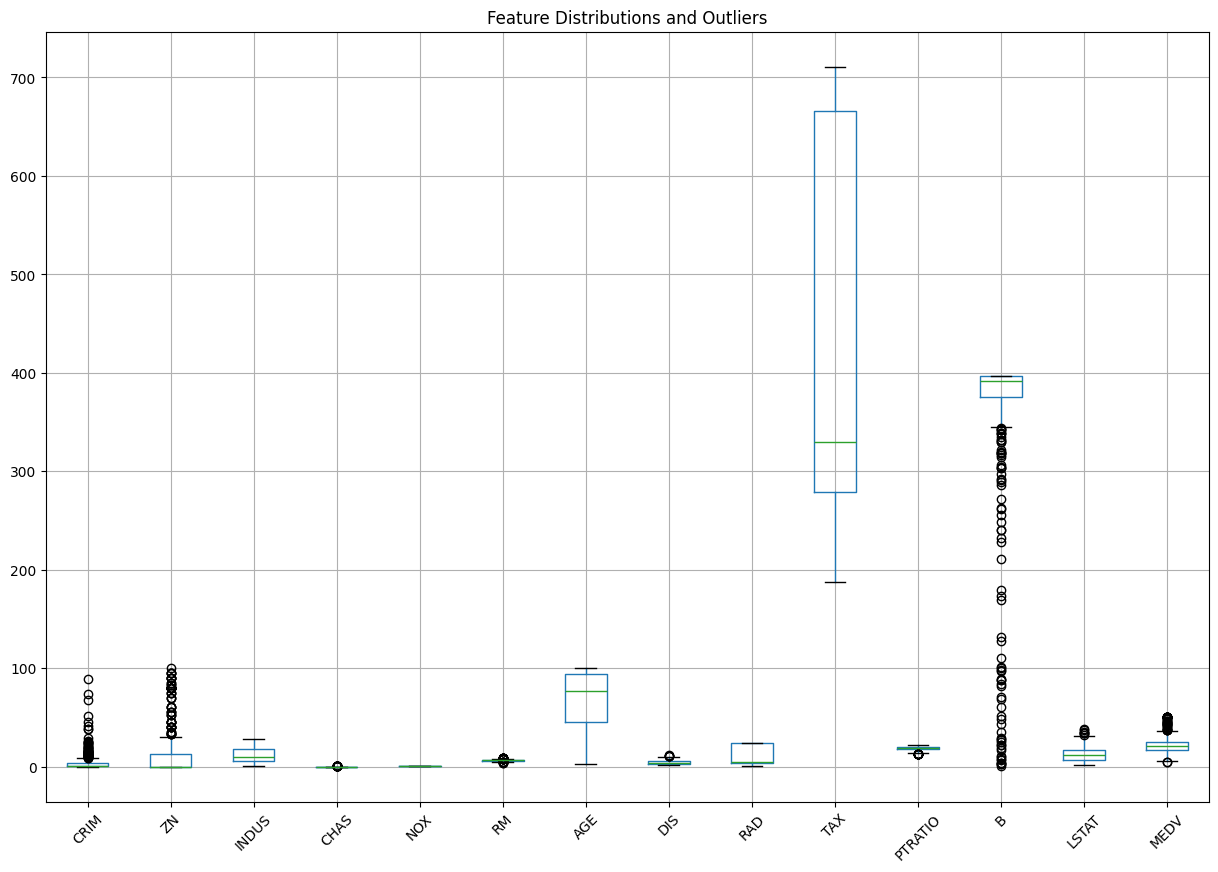

In [10]:
# 이상치 탐지를 위한 시각화
plt.figure(figsize=(15, 10))
df.boxplot()
plt.title('Feature Distributions and Outliers')
plt.xticks(rotation=45)
plt.show()

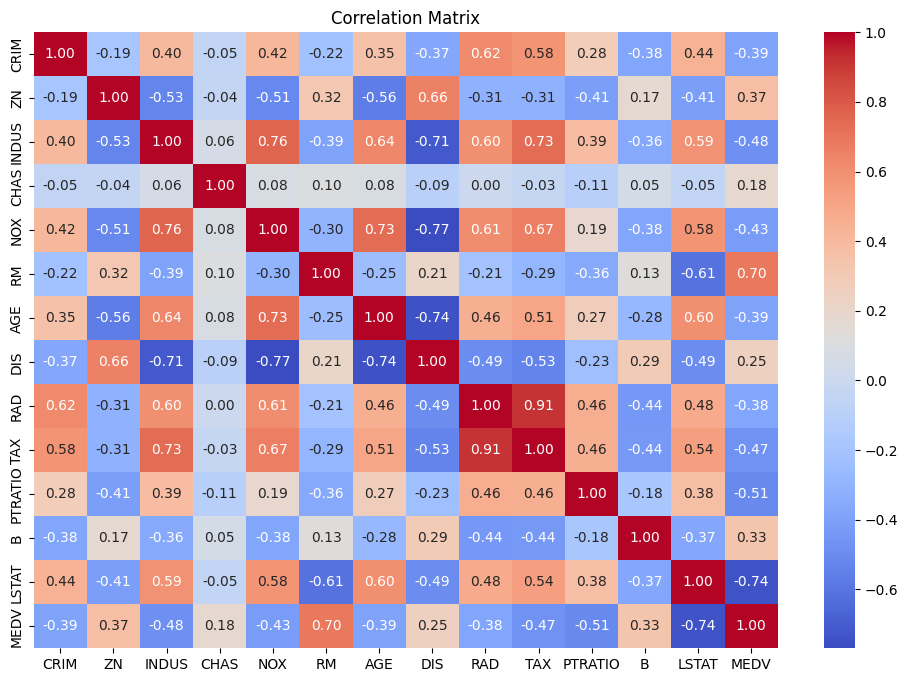

In [11]:
# 상관관계 분석
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [48]:
# 세 가지 이상치 제거 방법 정의

def create_features(df_processed):
    """특성 선택 및 생성 함수"""
    # RM(방 개수) 관련 특성
    df_processed['RM_squared'] = df_processed['RM'] ** 2

    # LSTAT(저소득층 비율) 관련 특성
    df_processed['LSTAT_squared'] = df_processed['LSTAT'] ** 2

    # 상호작용 특성
    df_processed['RM_LSTAT'] = df_processed['RM'] * df_processed['LSTAT']
    df_processed['RM_AGE'] = df_processed['RM'] * df_processed['AGE']
    df_processed['LSTAT_AGE'] = df_processed['LSTAT'] * df_processed['AGE']

    # NOX(일산화질소 농도)와 INDUS(비소매상업지역 비율) 상호작용
    df_processed['NOX_INDUS'] = df_processed['NOX'] * df_processed['INDUS']

    return df_processed

def remove_outliers_current(df):
    """현재 방식: 1%, 99% 기준"""
    df_processed = df.copy()
    for column in df.columns:
        Q1 = df[column].quantile(0.01)
        Q3 = df[column].quantile(0.99)
        df_processed = df_processed[
            (df_processed[column] >= Q1) &
            (df_processed[column] <= Q3)
        ]
    return create_features(df_processed)  # 특성 생성 추가

def remove_outliers_iqr(df):
    """IQR 방식"""
    df_processed = df.copy()
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        df_processed = df_processed[
            (df_processed[column] >= Q1 - 1.5*IQR) &
            (df_processed[column] <= Q3 + 1.5*IQR)
        ]
    return create_features(df_processed)  # 특성 생성 추가

def remove_outliers_zscore(df):
    """Z-score 방식 (임계값: ±3)"""
    df_processed = df.copy()
    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()
        z_scores = (df[column] - mean) / std
        df_processed = df_processed[abs(z_scores) <= 3]
    return create_features(df_processed)  # 특성 생성 추가

In [50]:
# 이상치 제거 방법 비교
methods = {
   'Current (1%, 99%)': remove_outliers_current,
   'IQR': remove_outliers_iqr,
   'Z-score': remove_outliers_zscore
}

outlier_removal_results = {}
for method_name, method_func in methods.items():
   # 이상치 제거
   df_cleaned = method_func(df)

   # 추가 특성 생성
   df_cleaned['RM_squared'] = df_cleaned['RM'] ** 2
   df_cleaned['LSTAT_squared'] = df_cleaned['LSTAT'] ** 2
   df_cleaned['RM_LSTAT'] = df_cleaned['RM'] * df_cleaned['LSTAT']
   df_cleaned['RM_AGE'] = df_cleaned['RM'] * df_cleaned['AGE']
   df_cleaned['LSTAT_AGE'] = df_cleaned['LSTAT'] * df_cleaned['AGE']
   df_cleaned['NOX_INDUS'] = df_cleaned['NOX'] * df_cleaned['INDUS']

   # 데이터 분할
   X = df_cleaned.drop('MEDV', axis=1)
   y = df_cleaned['MEDV']

   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                      random_state=42)

   # 스케일링
   scaler = StandardScaler()
   X_train_scaled = scaler.fit_transform(X_train)
   X_test_scaled = scaler.transform(X_test)

   # Random Forest 학습
   rf = RandomForestRegressor(random_state=42)
   rf.fit(X_train_scaled, y_train)

   # 예측
   y_pred = rf.predict(X_test_scaled)

   # 성능 평가
   outlier_removal_results[method_name] = {
       'Samples': len(df_cleaned),
       'MAE': mean_absolute_error(y_test, y_pred),
       'MSE': mean_squared_error(y_test, y_pred),
       'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
       'R2': r2_score(y_test, y_pred)
   }

In [51]:
# 이상치 제거 방법 비교 결과 출력
outlier_results_df = pd.DataFrame(outlier_removal_results).T
print("\n이상치 제거 방법별 성능 비교:")
print(outlier_results_df)


이상치 제거 방법별 성능 비교:
                   Samples       MAE       MSE      RMSE        R2
Current (1%, 99%)    337.0  1.906338  7.232896  2.689404  0.865542
IQR                  214.0  1.943302  6.809686  2.609538  0.631651
Z-score              321.0  1.965185  7.925533  2.815232  0.747432


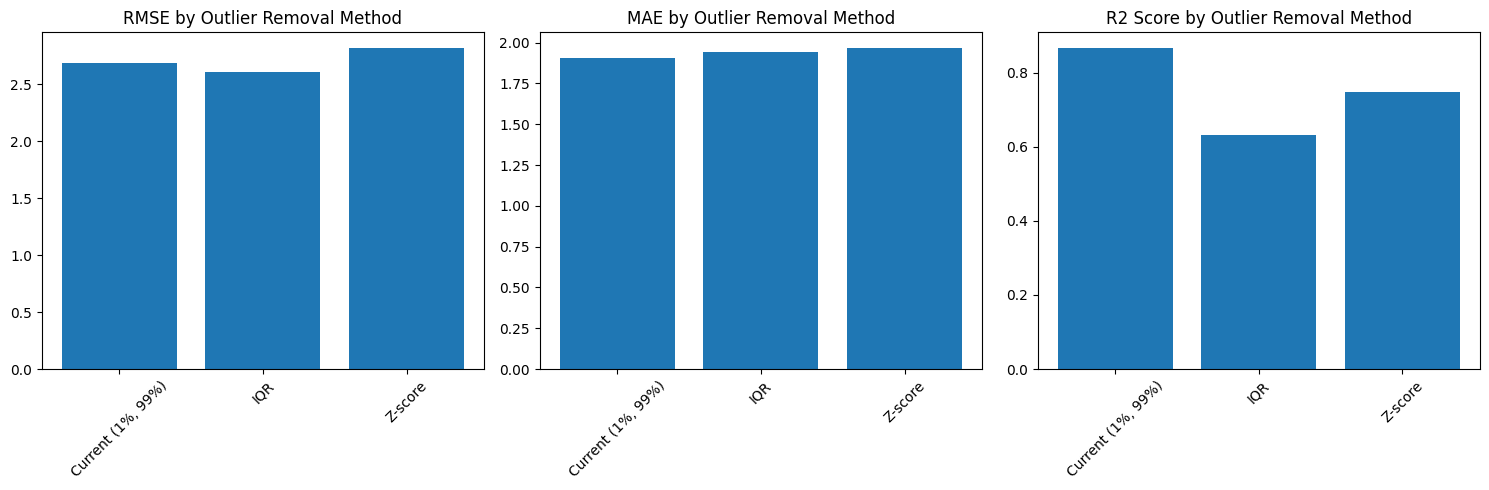

In [53]:
# 이상치 제거 방법별 성능 시각화
plt.figure(figsize=(15, 5))

# RMSE 비교
plt.subplot(1, 3, 1)
plt.bar(outlier_results_df.index, outlier_results_df['RMSE'])
plt.title('RMSE by Outlier Removal Method')
plt.xticks(rotation=45)

# MAE 비교
plt.subplot(1, 3, 2)
plt.bar(outlier_results_df.index, outlier_results_df['MAE'])
plt.title('MAE by Outlier Removal Method')
plt.xticks(rotation=45)

# R2 비교
plt.subplot(1, 3, 3)
plt.bar(outlier_results_df.index, outlier_results_df['R2'])
plt.title('R2 Score by Outlier Removal Method')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [54]:
# 최적의 방법으로 전처리된 데이터로 계속 진행
df_processed = remove_outliers_current(df)  # 가장 좋은 성능을 보인 방법 사용

In [55]:
# 특성 생성
df_processed['RM_squared'] = df_processed['RM'] ** 2
df_processed['LSTAT_squared'] = df_processed['LSTAT'] ** 2
df_processed['RM_LSTAT'] = df_processed['RM'] * df_processed['LSTAT']
df_processed['RM_AGE'] = df_processed['RM'] * df_processed['AGE']
df_processed['LSTAT_AGE'] = df_processed['LSTAT'] * df_processed['AGE']
df_processed['NOX_INDUS'] = df_processed['NOX'] * df_processed['INDUS']

# 특성과 타겟 분리
X = df_processed.drop('MEDV', axis=1)
y = df_processed['MEDV']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. 모델 정의

In [26]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR()
}

In [43]:
# 랜덤 포레스트 하이퍼파라미터 최적화
rf_params = {
   'n_estimators': [100, 200, 300],
   'max_depth': [10, 20, None],
   'min_samples_split': [2, 5, 10],
   'min_samples_leaf': [1, 2, 4],
   'max_features': ['auto', 'sqrt', 'log2']
}

print("\n=== Random Forest 하이퍼파라미터 최적화 ===")
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

print("\n최적 파라미터:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

# 최적화된 랜덤 포레스트로 업데이트
models['Random Forest'] = RandomForestRegressor(**grid_search.best_params_, random_state=42)


=== Random Forest 하이퍼파라미터 최적화 ===

최적 파라미터: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE: 2.3609207143959487


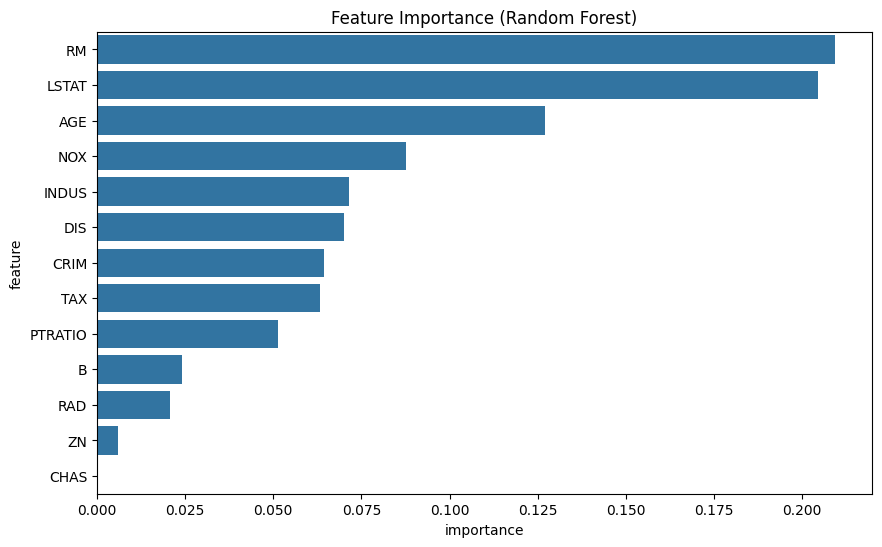

In [47]:
# 특성 중요도 시각화 (랜덤 포레스트 기준)
feature_importance = pd.DataFrame({
   'feature': X.columns,
   'importance': models['Random Forest'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Random Forest)')
plt.show()

# 3. 모델 학습 및 성능 평가

In [56]:
results = {}

for name, model in models.items():
   # 모델 학습
   model.fit(X_train_scaled, y_train)

   # 예측
   y_pred = model.predict(X_test_scaled)

   # 성능 평가
   mae = mean_absolute_error(y_test, y_pred)
   mse = mean_squared_error(y_test, y_pred)
   rmse = np.sqrt(mse)
   r2 = r2_score(y_test, y_pred)

   results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

# 모델 성능 비교 결과 출력
results_df = pd.DataFrame(results).T
print("\n모델별 성능 비교:")
print(results_df)


모델별 성능 비교:
                        MAE        MSE      RMSE        R2
Linear Regression  1.905186   5.663082  2.379723  0.894725
Ridge              1.815211   5.562689  2.358535  0.896591
Decision Tree      2.907353  17.202206  4.147554  0.680215
Random Forest      1.720265   4.899051  2.213380  0.908928
Gradient Boosting  1.751061   6.390229  2.527890  0.881207
SVR                2.385131  10.965509  3.311421  0.796154


In [45]:
# 교차 검증을 통한 모델 성능 평가
print("\n=== 교차 검증 결과 ===")
for name, model in models.items():
   scores = cross_val_score(model, X_train_scaled, y_train,
                          cv=5, scoring='neg_mean_squared_error')
   rmse_scores = np.sqrt(-scores)
   print(f'{name} CV RMSE: {rmse_scores.mean():.3f} (+/- {rmse_scores.std()*2:.3f})')


=== 교차 검증 결과 ===
Linear Regression CV RMSE: 2.773 (+/- 0.679)
Ridge CV RMSE: 2.759 (+/- 0.707)
Decision Tree CV RMSE: 3.476 (+/- 0.720)
Random Forest CV RMSE: 2.307 (+/- 1.008)
Gradient Boosting CV RMSE: 2.366 (+/- 0.913)
SVR CV RMSE: 3.179 (+/- 1.391)


# 4. 성능 시각화

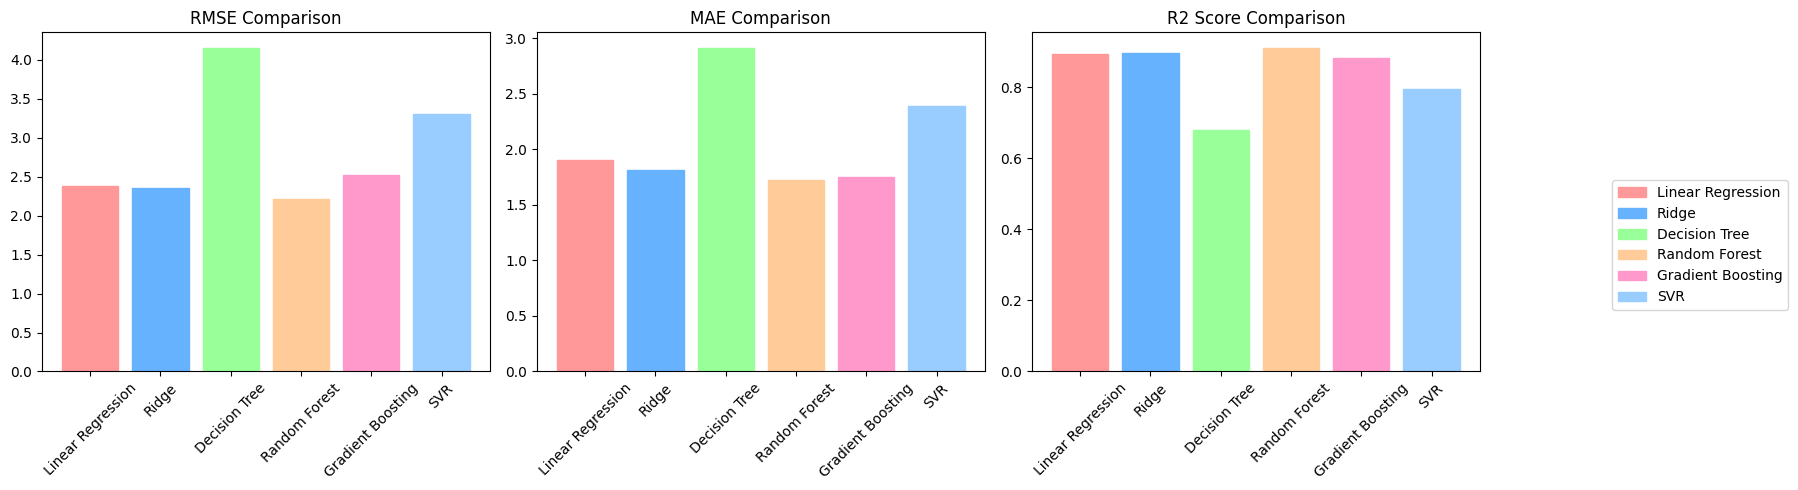

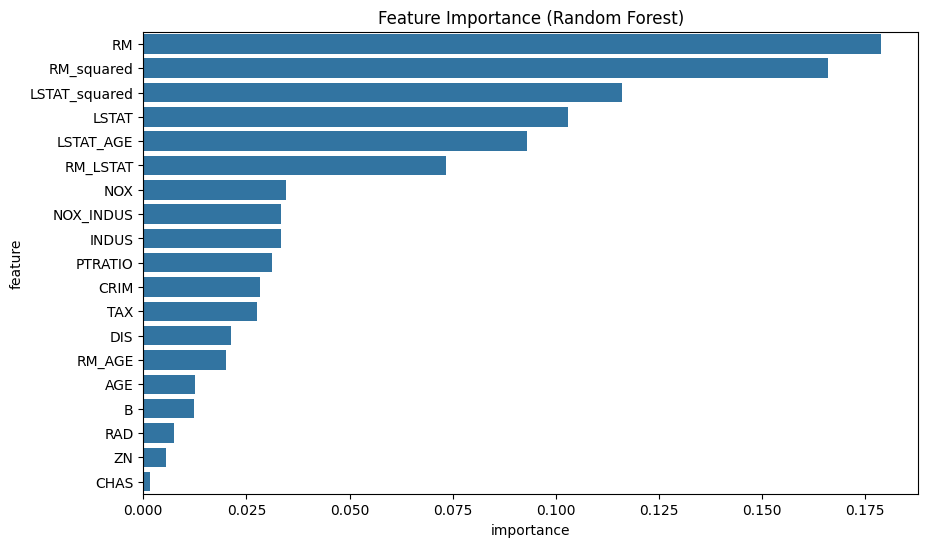

In [59]:
# 모델 성능 시각화
colors = {
   'Linear Regression': '#FF9999',
   'Ridge': '#66B2FF',
   'Decision Tree': '#99FF99',
   'Random Forest': '#FFCC99',
   'Gradient Boosting': '#FF99CC',
   'SVR': '#99CCFF'
}

plt.figure(figsize=(15, 5))

# RMSE 비교
plt.subplot(1, 3, 1)
bars1 = plt.bar(results_df.index, results_df['RMSE'])
for i, bar in enumerate(bars1):
   bar.set_color(colors[results_df.index[i]])
plt.title('RMSE Comparison')
plt.xticks(rotation=45)

# MAE 비교
plt.subplot(1, 3, 2)
bars2 = plt.bar(results_df.index, results_df['MAE'])
for i, bar in enumerate(bars2):
   bar.set_color(colors[results_df.index[i]])
plt.title('MAE Comparison')
plt.xticks(rotation=45)

# R2 비교
plt.subplot(1, 3, 3)
bars3 = plt.bar(results_df.index, results_df['R2'])
for i, bar in enumerate(bars3):
   bar.set_color(colors[results_df.index[i]])
plt.title('R2 Score Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.figlegend(bars1, colors.keys(),
             loc='center right',
             bbox_to_anchor=(1.2, 0.5))
plt.show()

# 특성 중요도 시각화
feature_importance = pd.DataFrame({
   'feature': X.columns,
   'importance': models['Random Forest'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Random Forest)')
plt.show()